In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [1]:
def dlt(originals_ps, correspondence_ps):  ## numpy arrays of the same size
    #check that photo matrix has y axis that go horizontally and x goes vertically
    ##RE THINK HOW POINTS CAME AS INPUT? AS we are used to or how the axis in comp vision comes
    #ps indicates its pixel space
    points_number = np.shape(originals_ps)[0];
    ## o =  orignals
    ## c = correspondence
    
    o_centroid = np.mean(originals_ps, axis=0)
    c_centroid = np.mean(correspondence_ps, axis=0)
    
    o_centered = originals_ps - np.tile(o_centroid, (points_number,1))
    c_centered = correspondence_ps - np.tile(c_centroid, (points_number,1))
    
    o_norms = np.linalg.norm(o_centered, axis=1)
    c_norms = np.linalg.norm(c_centered, axis=1)                                           
    
    o_distance = np.mean(o_norms)
    c_distance = np.mean(c_norms)
                                          
    o_scale = np.sqrt(2)/o_distance
    c_scale = np.sqrt(2)/c_distance
    
    H_sim_prim = np.array([[c_scale,0      ,-c_centroid[0]*c_scale],
                          [0      ,c_scale,-c_centroid[1]*c_scale],
                          [0      ,0      ,1]])

    
    H_sim = np.array([[o_scale,0      ,-o_centroid[0]*o_scale],
                      [0      ,o_scale,-o_centroid[1]*o_scale],
                      [0      ,0      ,1]])
    
    o_pr = np.c_[ originals_ps, np.ones(points_number) ]
    c_pr = np.c_[correspondence_ps, np.ones(points_number)]

    o_homologous = np.transpose(H_sim @ np.transpose(o_pr))
    c_homologous = np.transpose(H_sim_prim @ np.transpose(c_pr))

    #We send it to the proyective plane
    
    H_sim_prim = np.linalg.inv(H_sim_prim)
                                             
    A = np.zeros((points_number*2,9))

    zerot = np.array([0,0,0])

    for i in range(0, points_number):
        xt = o_homologous[i, :]
        
        wixt = c_homologous[i,2] * xt
        yixt = c_homologous[i,1] * xt
        xixt = c_homologous[i,0] * xt
        A[2*i,:] = np.concatenate((zerot, -wixt, yixt))
        A[2*i + 1,:] = np.concatenate((wixt, zerot, -xixt))
    (u,d,v) = np.linalg.svd(A)
    
    H = np.reshape(v[-1, :], (3,3))
    H = np.dot(H, H_sim)
    H = np.dot(H_sim_prim, H)
    H = H/H[2,2]
    return H

def transf_dlt(H, img):
    H_inv = np.linalg.inv(H)
    img_transf = np.zeros(img.shape)
    print(img_transf.shape)
    vect_ant = np.array([-1,-1,-1])
    print(H_inv)
    print(H)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            vect = np.array([x,y,1])
            vect = H_inv @ vect
            vect = vect/vect[2]
            x_pr = int(vect[0])
            y_pr = int(vect[1])

            if (y_pr < img.shape[0] and  y_pr>= 0) and (x_pr< img.shape[1] and  x_pr>= 0):
                img_transf[y, x, :] = img[y_pr,x_pr,:].astype(np.uint8)

    return img_transf

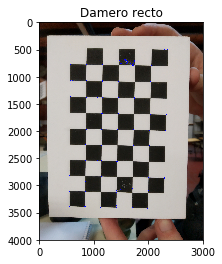

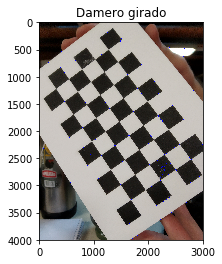

True

In [3]:
damero = cv2.imread('../../dameros/IMG_20181030_174017.jpg')
damero_twist = cv2.imread('../../dameros/IMG_20181030_174022.jpg')
estrella = cv2.imread('estrella.png')
estrella_r = cv2.imread('estrella_r.png')

gray = cv2.cvtColor(damero,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,100,0.01,10)
corners = np.int0(corners)

cant = 0
for i in corners:
    x,y = i.ravel()
    if(y >= 500 and y <= 3500 and x >= 500 and x <= 2500):
        cv2.circle(damero,(x,y),10,255,-1)
        cant += 1

plt.title("Damero recto")
plt.imshow(damero[:,:,::-1]),plt.show()

cv2.imwrite('damero.png', damero)

gray_twist = cv2.cvtColor(damero_twist,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray_twist,100,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(damero_twist,(x,y),10,255,-1)

plt.title("Damero girado")
plt.imshow(damero_twist[:,:,::-1]),plt.show()
cv2.imwrite('damero_twist.png', damero_twist)

In [4]:
rect_puntos = np.array([[2358, 510,1],[872, 482,1],[560, 3377,1], [1993, 3137,1]])
gir_puntos = np.array([[1353, 113,1],[169, 1001,1],[1600, 3727,1], [2784, 2521,1]])

H = dlt(gir_puntos, rect_puntos)
H_gir = dlt(rect_puntos, gir_puntos)

ValueError: shapes (3,3) and (4,4) not aligned: 3 (dim 1) != 4 (dim 0)

In [ ]:
for pt in gir_puntos:
    print(H@pt)

In [ ]:
recto_a_girado = transf_dlt(H, damero)
recto_a_girado = recto_a_girado.astype(np.uint8)

girado_a_recto = transf_dlt(H_gir, damero_twist)
girado_a_recto = girado_a_recto.astype(np.uint8)

In [ ]:
print(H)

In [ ]:
print(H)

In [ ]:
plt.figure(1, figsize=(20,20))

# linear
plt.subplot(221)
plt.title("Damero")
plt.imshow(damero[:,:,::-1])

plt.subplot(222)
plt.plot(x, y)
plt.title('Girado a recto')
plt.imshow(girado_a_recto[:,:,::-1])

plt.subplot(223)
plt.title("Damero girado")
plt.imshow(damero_twist[:,:,::-1])

plt.subplot(224)
plt.title("recto a girado")
plt.imshow(recto_a_girado[:,:,::-1])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.05)
plt.show()

Se eligieron cuatro puntos a mano de los encontrados con el detector de esquinas de harris, parece ser que la parte proyectiva de la matriz no esta siendo calculada. esto puede ser causado por los puntos que agarramos.

In [ ]:
print(H)
print("--------------------------")
print(H_gir)

In [ ]:
damero = cv2.imread('../../dameros/IMG_20181030_174017.jpg')
damero_twist = cv2.imread('../../dameros/IMG_20181030_174022.jpg')
estrella = cv2.imread('estrella.png')
estrella_r = cv2.imread('estrella_r.png')
gray = cv2.cvtColor(damero,cv2.COLOR_BGR2GRAY)
gray_twist = cv2.cvtColor(damero_twist,cv2.COLOR_BGR2GRAY)

gray_s = cv2.cvtColor(estrella,cv2.COLOR_BGR2GRAY)
gray_twist_s = cv2.cvtColor(estrella_r,cv2.COLOR_BGR2GRAY)


In [ ]:
print(gray.shape)

In [5]:
sift = cv2.xfeatures2d.SIFT_create()

(kps, desc) = sift.detectAndCompute(gray, None)

(kps_twist, desc_twist) = sift.detectAndCompute(gray_twist, None)

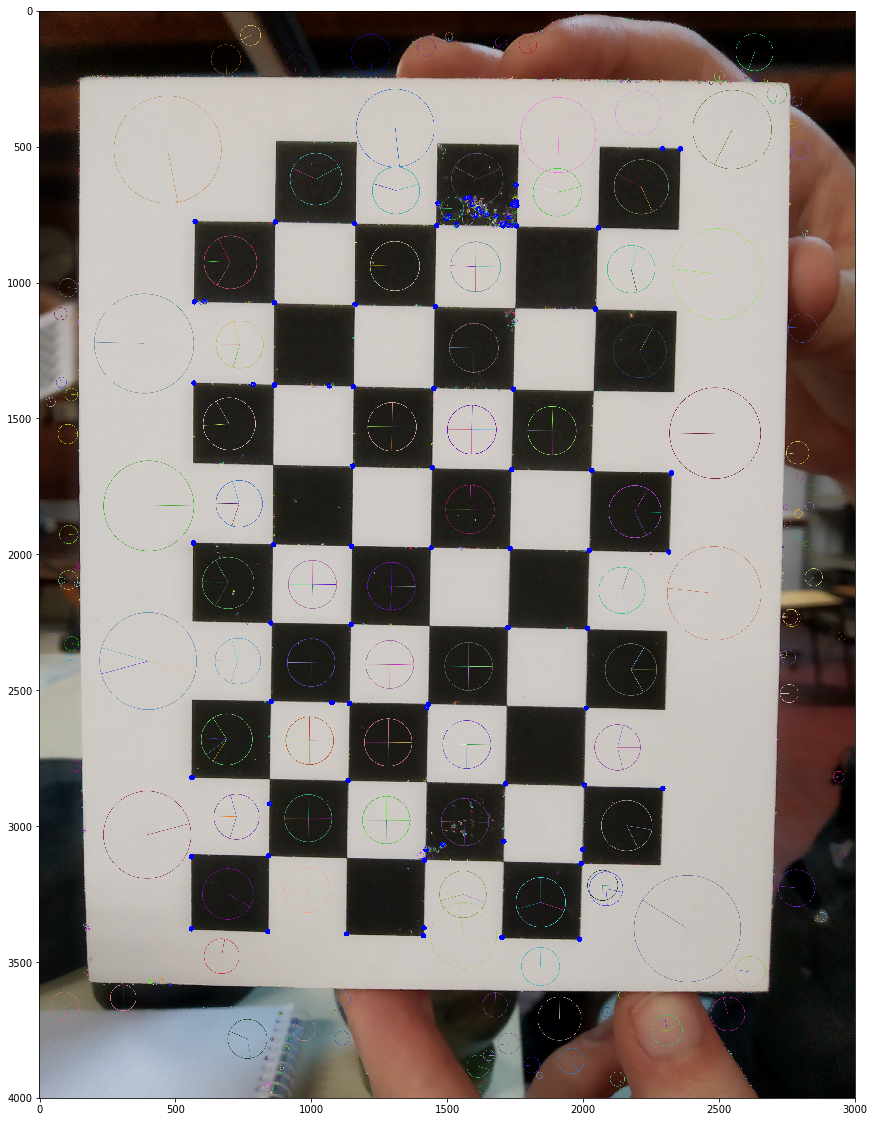

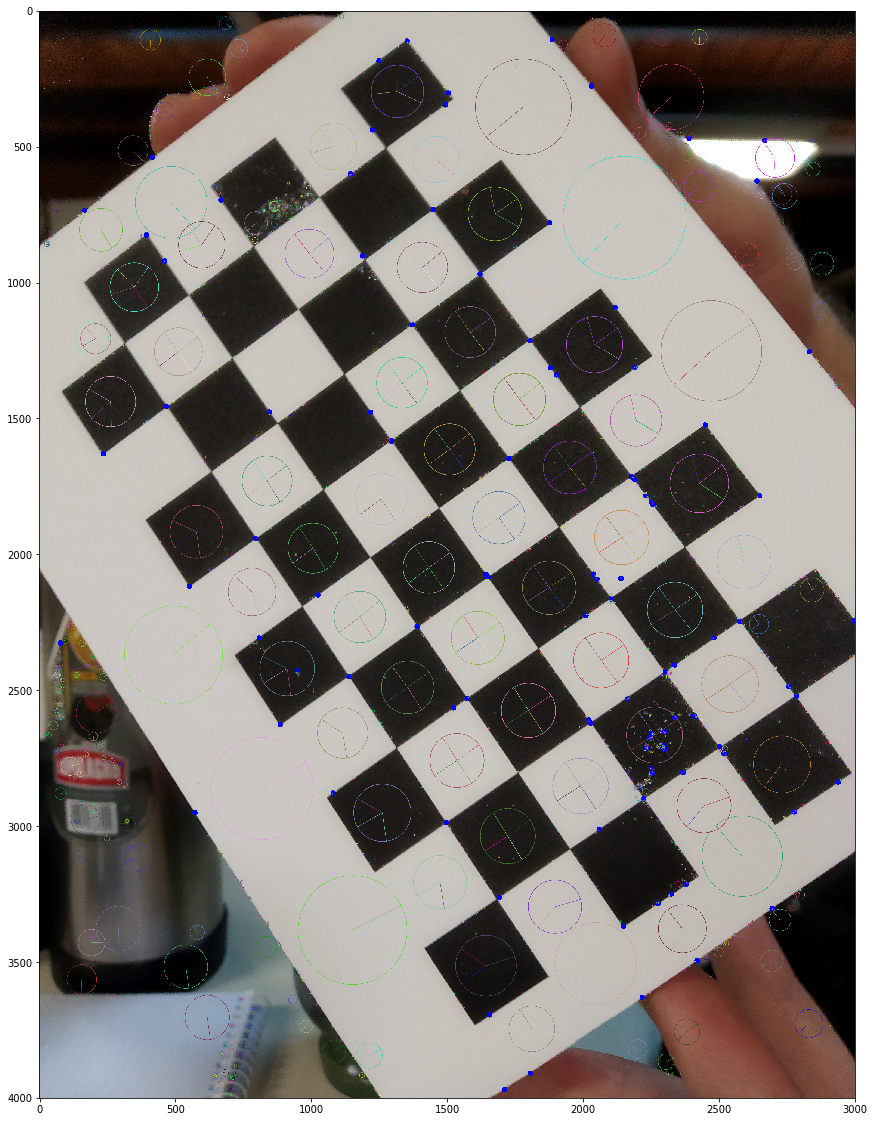

(<matplotlib.image.AxesImage at 0x7f5ea4fd5160>, None)

In [6]:
aux = damero
aux2 = damero
plt.figure(4, figsize=(20,20))
cv2.drawKeypoints(damero, kps, aux, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(aux[:,:,::-1]),plt.show()
plt.figure(3,figsize=(20,20))
cv2.drawKeypoints(damero_twist, kps_twist, aux2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(aux2[:,:,::-1]),plt.show()

In [7]:
orb = cv2.ORB_create()
# find the keypoints with ORB
#kps = orb.detect(gray,None)
# compute the descriptors with ORB
o_kps, o_desc = orb.detectAndCompute(gray, None)
#kps_twist = orb.detect(gray_twist, None)
o_kps_twist, o_desc_twist = orb.detectAndCompute(gray_twist, None)

In [8]:
def get_keypoints_desc(gray, gray_twist):
    orb = cv2.ORB_create()
    o_kps, o_desc = orb.detectAndCompute(gray, None)

    o_kps_twist, o_desc_twist = orb.detectAndCompute(gray_twist, None)
    
    return (o_kps, o_desc, o_kps_twist, o_desc_twist)

In [9]:
def get_matches(desc, desc_twist):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=False)

    matches = bf.knnMatch(desc,desc_twist, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if n.distance*1.05 > m.distance and m.distance < 0.95*n.distance:
            good.append([m])
    
    return (matches, good)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# Match descriptors.
matches_orb = bf.match(desc,desc_twist)

# Sort them in the order of their distance.
matches_orb = sorted(matches_orb, key = lambda x:x.distance)
y_max, x_max = (0,0)
for kp in kps:
    if kp.pt[0]>x_max:
        x_max = kp.pt[0]
    if kp.pt[1] > y_max:
        y_max = kp.pt[1]

print(x_max, y_max)

In [10]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=False)

k_matches = bf.knnMatch(o_desc,o_desc_twist, k=2)

# Apply ratio test
good = []
for m,n in k_matches:
    if n.distance*1.05 > m.distance and m.distance < 0.95*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
#img3 = cv2.drawMatchesKnn(damero,kps,damero_twist,kps_twist,good,flags=2)

#plt.imshow(img3),plt.show()

#Match descriptors.
#matches = bf.match(desc,desc_twist)

# Sort them in the order of their distance.
#matches = sorted(matches, key = lambda x:x.distance)

#Draw first 10 matches.
#aux = matches[0]
#cv2.drawMatches(damero,kps,damero_twist,kps_twist,matches[:50], outImg = img3, flags=0)


#plt.imshow(img3),plt.show()

In [11]:
def show_matches(img1, img2, kps, kps2, matches, good, cant_show):
    aux = np.concatenate((img1,img2), axis=1)
    x_offset = img1.shape[1]
    print(img1.shape)
    if len(aux.shape) == 3: 
        plt.imshow(aux[:,:,::-1])
    else:
        plt.imshow(aux)
        
    for match, match2 in matches[:cant_show]:
        x, y = kps[match.queryIdx].pt
        xt, yt = kps2[match.trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro-', linewidth=0.8, markersize=1)
        x, y = kps[match2.queryIdx].pt
        xt, yt = kps2[match2.trainIdx].pt
        #plt.plot([x,xt+3000], [y,yt], 'bo', linewidth=0.8, markersize=1)
    plt.show()
    
    if len(aux.shape) == 3: 
        plt.imshow(aux)#[:,:,::-1])
    else:
        plt.imshow(aux)
    
    for match in matches[:cant_show]:
        x, y = kps[match[0].queryIdx].pt
        xt, yt = kps2[match[0].trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro', linewidth=0.8, markersize=1)
    plt.show()
    
    if len(aux.shape) == 3: 
        plt.imshow(aux)#[:,:,::-1])
    else:
        plt.imshow(aux)
        
    for match in good[:cant_show]:
        x, y = kps[match[0].queryIdx].pt
        xt, yt = kps2[match[0].trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro-', linewidth=0.8, markersize=1)
        x, y = kps[match2.queryIdx].pt
        xt, yt = kps2[match2.trainIdx].pt
        #plt.plot([x,xt+3000], [y,yt], 'bo', linewidth=0.8, markersize=1)
    plt.show()
    if len(aux.shape) == 3: 
        plt.imshow(aux[:,:,::-1])
    else:
        plt.imshow(aux)
    for match in good[:cant_show]:
        x, y = kps[match[0].queryIdx].pt
        xt, yt = kps2[match[0].trainIdx].pt
        plt.plot([x,xt+x_offset], [y,yt], 'ro', linewidth=0.8, markersize=1)
    plt.show()
    

In [12]:
print(gray_s.shape)
kps, desc, kps2, desc2 = get_keypoints_desc(gray, gray_twist)
matches, good = get_matches(desc, desc2)
show_matches(gray, gray_twist, kps, kps2, matches, good, 5)

NameError: name 'gray_s' is not defined

In [ ]:
print(damero.shape, damero_twist.shape)
aux = np.concatenate((damero, damero_twist), axis = 1)
print(aux.shape)
print(len(matches))
plt.imshow(aux[:,:,::-1])


for match, match2 in k_matches[:50]:
    x, y = o_kps[match.queryIdx].pt
    xt, yt = o_kps_twist[match.trainIdx].pt
    #xi, yi = match.imgIdx.pt
    plt.plot([x,xt+3000], [y,yt], 'ro', linewidth=0.8, markersize=1)
    x, y = o_kps[match2.queryIdx].pt
    xt, yt = o_kps_twist[match2.trainIdx].pt
    #plt.plot([x,xt+3000], [y,yt], 'bo', linewidth=0.8, markersize=1)
plt.show()

Arriba mostramos las primeras 50 correspondencias, no parece ser que este andando bien knn, abajo estan 10 de las mejores donde nos aseguramos que los vecinos esten cerca.

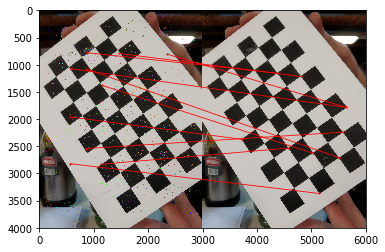

In [22]:
plt.imshow(aux[:,:,::-1])
for match in good[:10]:
    x, y = o_kps[match[0].queryIdx].pt
    xt, yt = o_kps_twist[match[0].trainIdx].pt
    plt.plot([x,xt+3000], [y,yt], 'ro-', linewidth=0.8, markersize=1)
plt.show()

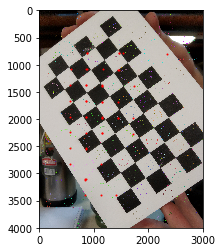

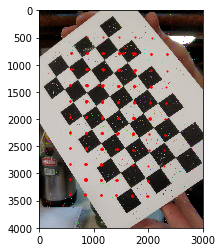

In [23]:
plt.imshow(damero[:,:,::-1])
for key, key2 in k_matches[:50]:
    x, y = o_kps[key.queryIdx].pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()

plt.imshow(damero[:,:,::-1])
for key in o_kps:
    x, y = key.pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()

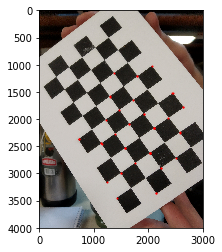

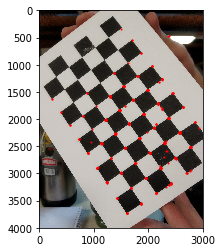

In [24]:
plt.imshow(damero_twist[:,:,::-1])
for key, key2 in k_matches[:50]:
    x, y = o_kps_twist[key.trainIdx].pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()


plt.imshow(damero_twist[:,:,::-1])
for key in o_kps_twist:
    x, y = key.pt
    plt.plot(x, y, 'ro', markersize=1)
plt.show()

In [25]:
alphas = {0.9: 4.605, 0.95:5.991, 0.99:9.210}
desvios = [1, 0.5, 1.5]
t_estandar = alphas[0.95]*desvios[1]
sample_size = 2
#points is a np.ndarray

def create_homografic(originals, correspondences):
    ab_ind = np.random.choice(originals.shape[0], size = 2, replace = False) 
    a_ind = ab_ind[0]
    b_ind = ab_ind[1]
    colineal = True
    a = originals[a_ind,:]
    b = originals[b_ind,:]
    ab = np.cross(a,b)
    c = a
    c_ind = a_ind
    while np.cross(ab, c) == 0:
        c_ind = np.random.choice(originals.shape[0])
        c = originals[c_ind, :]
    ac = np.cross(a,c)
    bc = np.cross(b,c)
    d = a
    d_ind = a_ind
    while np.cross(ab, d) == 0 or np.cross(bc, d) == 0 or np.cross(ac, d) == 0:
        d_ind = np.random.choice(originals.shape[0])
        d = originals[d_ind, :]
        
    return dlt(originals[[a_ind, b_ind, c_ind, d_ind]], correspondences[[a_ind, b_ind, c_ind, d_ind]])

    
    
def d_trans(H, original, correspondence):
    inverse = np.linalg.inv(H)
    d = np.linalg.norm(original, inverse @ correspondence)**2
    d += np.linalg.norm(correspondence, H @ original)
    
    return d

def ransac(originals, correspondences):
    t = 5.991 #desvio es 1
    n = 11 #outliers = 40%
    stoping_size = len(point)*0.6
    sample_size = 2
    H = np.array([])
    support = []
    points_idx = list(range(points.shape()[0]))
    
    for i in range(n):
        H_aux = create_homografic(originals, correspondences)
        cant = 0
        suport_aux = []
        for j in range(points.shape()[0]):
            distance = d_trans(H_aux, originals[j,:], correspondencess[j,:])
            if distance <= t:
                support_aux.append(j)
        if len(support) < len(support_aux):
                support = support_aux
                H = H_aux
        if cant >= stoping_size:
            break

    H_big = dlt(originals[support], correspondences[support])
    
    return H_big

In [26]:
puntos_recta = np.array([[339,241,1],[416,298,1], [385,388, 1], [291,387,1]])#, [262,297,1]])
puntos_rotadas = np.array([[415,40,1],[509,50,1],[528,143,1],[446,189,1]])#,[365,126,1]])

H = dlt(puntos_rotadas, puntos_recta)
H_gir = dlt(puntos_recta, puntos_rotadas)

In [27]:
girada_a_recta = transf_dlt(H_gir, estrella_r)
girada_a_recta = girada_a_recta.astype(np.uint8)

recta_a_girada = transf_dlt(H, estrella)
recta_a_girada = recta_a_girada.astype(np.uint8)


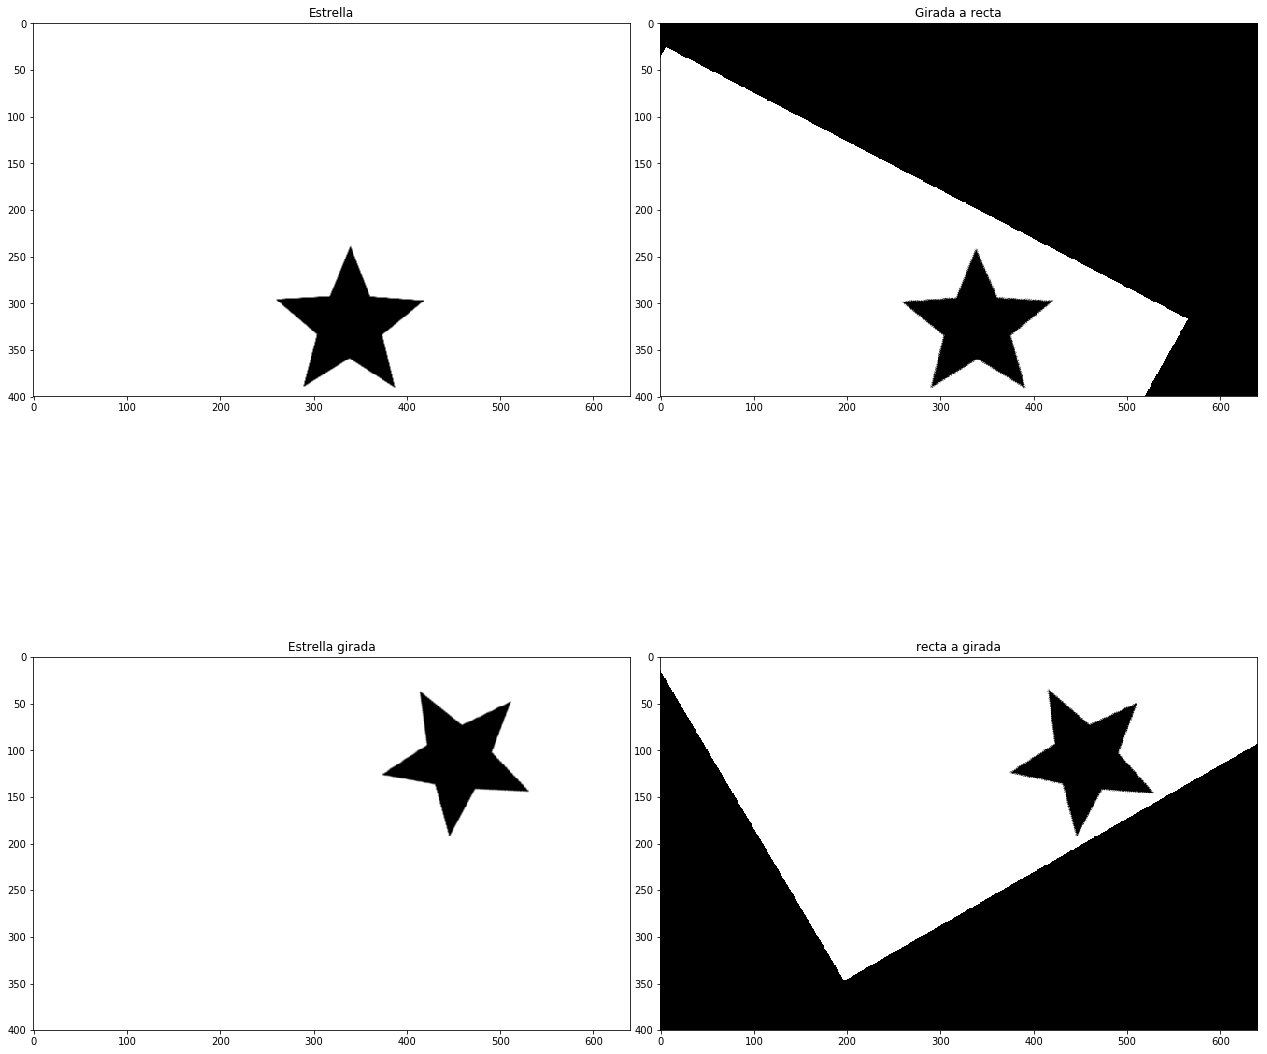

In [28]:
plt.figure(1, figsize=(20,20))

# linear
plt.subplot(221)
plt.title("Estrella")
plt.imshow(estrella)

plt.subplot(222)
plt.plot(x, y)
plt.title('Girada a recta')
plt.imshow(girada_a_recta[:,:,::-1])

plt.subplot(223)
plt.title("Estrella girada")
plt.imshow(estrella_r)

plt.subplot(224)
plt.title("recta a girada")
plt.imshow(recta_a_girada[:,:,::-1])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.05)
plt.show()

[[ 0.965 -0.258  0.   ]
 [ 0.258  0.965  0.   ]
 [ 0.     0.     1.   ]]
(400, 640, 3)
(400, 640, 3)


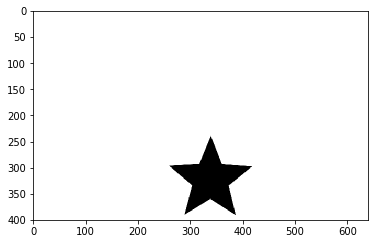

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


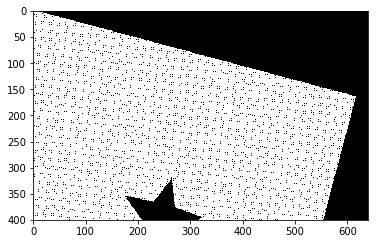

(<matplotlib.image.AxesImage at 0x7f5ea4f460f0>, None)

In [13]:
H_tr = np.array([[0.965, -0.258, 0], [0.258, 0.965, 0], [0, 0, 1]])
print(H_tr)
estrella_tr = np.zeros(estrella.shape)
print(estrella_tr.shape)
print(estrella.shape)
for y in range(estrella.shape[0]):
    for x in range(estrella.shape[1]):
        vect = np.array([x,y,1])
        #print(vect, H_tr @ vect)
        vect = H_tr @ vect
        vect = vect/vect[2]
        if(int(vect[1]) >= 0 and int(vect[1]) < 400) and (int(vect[0]) >= 0 and int(vect[0]) < 640):
            estrella_tr[int(vect[1]), int(vect[0]),:] = estrella[y,x,:]

plt.imshow(estrella),plt.show()
plt.imshow(estrella_tr),plt.show()


In [15]:
points = []
for x in range(0,estrella.shape[1], 50):
    for y in range(0, estrella.shape[0], 50):
        aux = [x,y]
        points.append(aux)

points = np.array(points)

In [16]:
point_rt = []
for vec in points:
    aux = [vec[0], vec[1], 1]
    vect = H_tr @ aux
    vect = vect / vect[2]
    point_rt.append([int(vect[0]), int(vect[1])])

point_rt = np.array(point_rt)

In [18]:
H = dlt(points, point_rt)

In [20]:
aux  = transf_dlt(H_tr, estrella)
aux = aux.astype(np.uint8)

sec = transf_dlt(H, estrella)
sec = sec.astype(np.uint8)

(400, 640, 3)
[[ 0.96713834  0.2585717   0.        ]
 [-0.2585717   0.96713834  0.        ]
 [ 0.          0.          1.        ]]
[[ 0.965 -0.258  0.   ]
 [ 0.258  0.965  0.   ]
 [ 0.     0.     1.   ]]
399 251 = [255 255 255] 450 139
399 252 = [255 255 255] 451 140
399 253 = [255 255 255] 451 141
399 254 = [255 255 255] 451 142
399 255 = [255 255 255] 451 143
399 256 = [255 255 255] 452 144
399 257 = [255 255 255] 452 145
399 258 = [255 255 255] 452 146
399 259 = [255 255 255] 452 147
399 260 = [255 255 255] 453 148


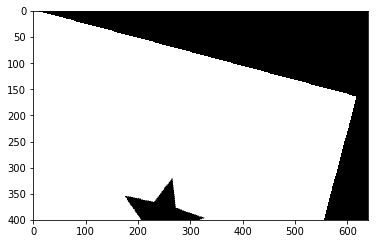

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


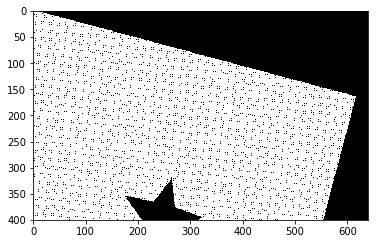

(400, 640, 3)
[[  9.69932030e-01   2.58724000e-01   1.27278901e-01]
 [ -2.58290523e-01   9.67847877e-01   2.36284653e-01]
 [  4.09937286e-06  -7.33387916e-07   1.00000006e+00]]
[[  9.62484556e-01  -2.57290330e-01  -6.17102168e-02]
 [  2.56860125e-01   9.64556468e-01  -2.60602749e-01]
 [ -3.75720472e-06   1.76212294e-06   1.00000000e+00]]
399 251 = [255 255 255] 451 139
399 252 = [255 255 255] 451 140
399 253 = [255 255 255] 451 141
399 254 = [255 255 255] 452 142
399 255 = [255 255 255] 452 143
399 256 = [255 255 255] 452 144
399 257 = [255 255 255] 452 145
399 258 = [255 255 255] 453 146
399 259 = [255 255 255] 453 147
399 260 = [255 255 255] 453 148


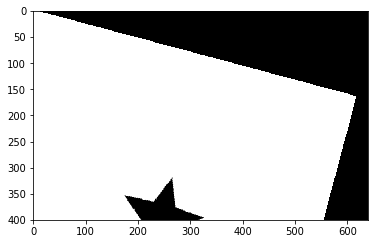

(<matplotlib.image.AxesImage at 0x7f5ea49334e0>, None)

In [22]:

plt.imshow(aux),plt.show()

plt.imshow(estrella_tr),plt.show()


plt.imshow(sec),plt.show()